## BirdCLEF+ 2025
### Data: birds sound

One sample of how we handle this type of data

Audio length: 382.30 seconds


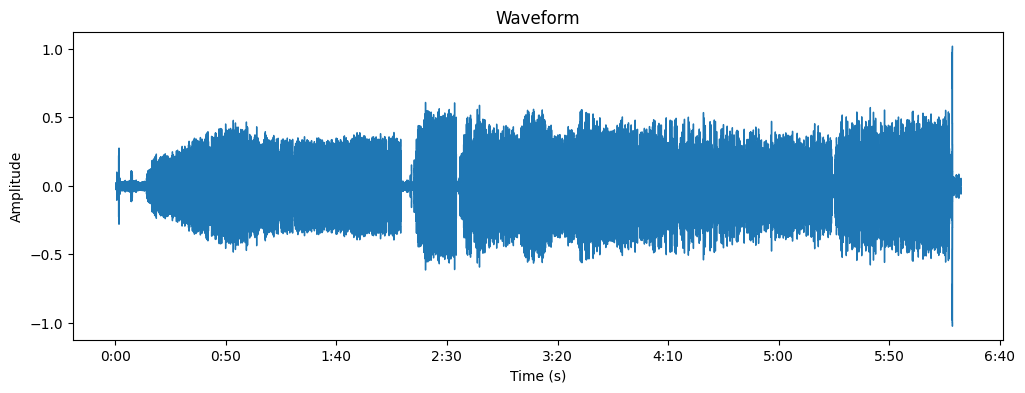

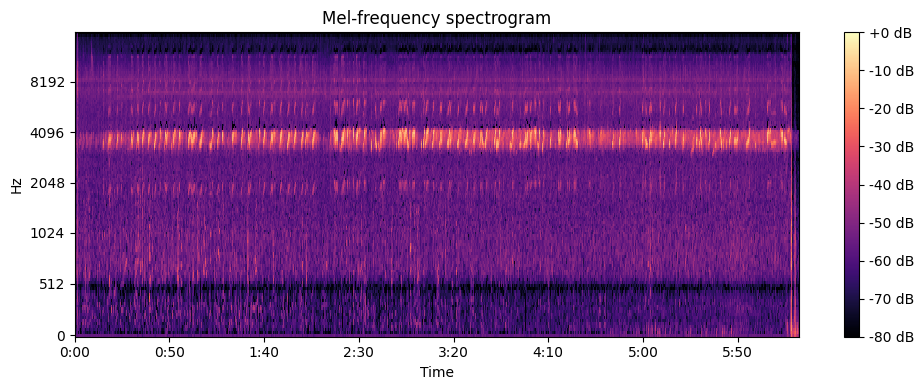

Mel spectrogram shape: (128, 23894)


In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load OGG file
file_path = r'F:\Desktop\BU\MA679\Final\birdclef-2025\train_audio\21038\iNat65519.ogg'

# Load the audio
y, sr = librosa.load(file_path, sr=None)  # y = audio waveform array, sr = sample rate
print(f"Audio length: {len(y)/sr:.2f} seconds")

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Convert audio to Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

print("Mel spectrogram shape:", mel_spec_db.shape)

Blog of Discret Cosine Transformation
http://datagenetics.com/blog/november32012/index.html

Filter banks, Mel-Frequency Cepstral Coefficients
https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Mel Frequency Cepstral Coefficient (MFCC) tutorial
http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


MFCC shape: (13, 23894)


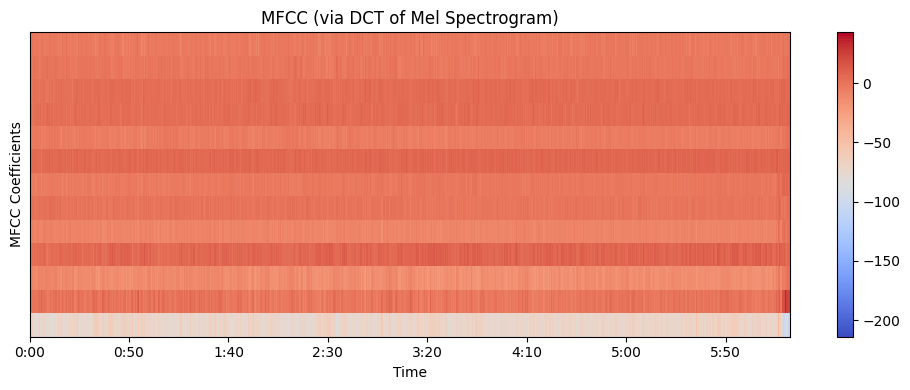

In [ ]:
# Tried DCT
log_mel_spec = np.log(mel_spec + 1e-9)  # Raw mel_spec preferred here
mfcc = dct(log_mel_spec, type=2, axis=0, norm='ortho')
mfcc = mfcc[:13, :] 

print("MFCC shape:", mfcc.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC (via DCT of Mel Spectrogram)')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Mel Filterbank Graph

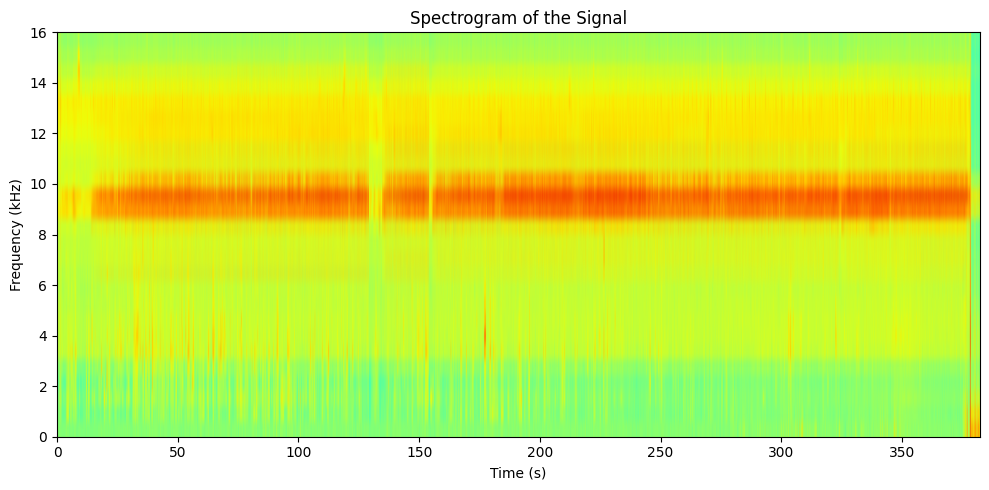

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import fft
from numpy import hamming
import librosa



def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)


# Load .ogg audio file using librosa
signal, sr = librosa.load('F:\\Desktop\\BU\\MA679\\Final\\birdclef-2025\\train_audio\\21038\\iNat65519.ogg', sr=None)

# Parameters
frame_size = 0.025  # 25 ms
frame_stride = 0.01  # 10 ms
frame_len = int(round(frame_size * sr))
frame_step = int(round(frame_stride * sr))
signal_length = len(signal)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_len)) / frame_step)) + 1

# Padding
pad_signal_length = num_frames * frame_step + frame_len
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(signal, z)

# Framing
indices = np.tile(np.arange(0, frame_len), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_len, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# Windowing
frames *= hamming(frame_len)

# FFT
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))

# Mel filterbank
nfilt = 26
low_mel = hz_to_mel(0)
high_mel = hz_to_mel(sr / 2)
mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
hz_points = mel_to_hz(mel_points)
bin = np.floor((NFFT + 1) * hz_points / sr).astype(int)

fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))
for m in range(1, nfilt + 1):
    f_m_minus = bin[m - 1]
    f_m = bin[m]
    f_m_plus = bin[m + 1]

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - f_m_minus) / (f_m - f_m_minus)
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (f_m_plus - k) / (f_m_plus - f_m)

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Avoid log(0)
filter_banks = 20 * np.log10(filter_banks)  # dB

# Plot Mel spectrogram
plt.figure(figsize=(10, 5))
plt.imshow(filter_banks.T, origin='lower', aspect='auto', cmap='jet',
           extent=[0, len(signal)/sr, 0, sr/2/1000])  # kHz
plt.title('Spectrogram of the Signal')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


In [27]:
import numpy as np
np.complex = complex  # Fix for librosa
import librosa
import matplotlib.pyplot as plt
from scipy.fftpack import dct
import os

def extract_mel_dct_features(audio_path, n_fft=512, n_mels=26, n_mfcc=13, save_dir='./output'):
    """
    Extracts Mel spectrogram and MFCCs from an audio file and saves them to disk.
    Also plots the Mel filter bank.
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)

    # Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Apply DCT to log Mel spectrogram
    log_mel_spec = np.log(mel_spec + 1e-9)
    mfcc = dct(log_mel_spec, type=2, axis=0, norm='ortho')[:n_mfcc]

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Save CSVs
    np.savetxt(os.path.join(save_dir, 'mel_spectrogram.csv'), mel_spec_db, delimiter=",")
    np.savetxt(os.path.join(save_dir, 'mfcc.csv'), mfcc, delimiter=",")

    # Plot and save Mel filter bank
    mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    fft_freqs = np.linspace(0, sr/2, int(1 + n_fft//2))

    plt.figure(figsize=(12, 4))
    for i in range(n_mels):
        plt.plot(fft_freqs, mel_filters[i])
    plt.title("Filter bank on a Mel-Scale")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mel_filterbank.png'))
    plt.close()

    return mfcc, mel_spec_db, mel_filters, fft_freqs

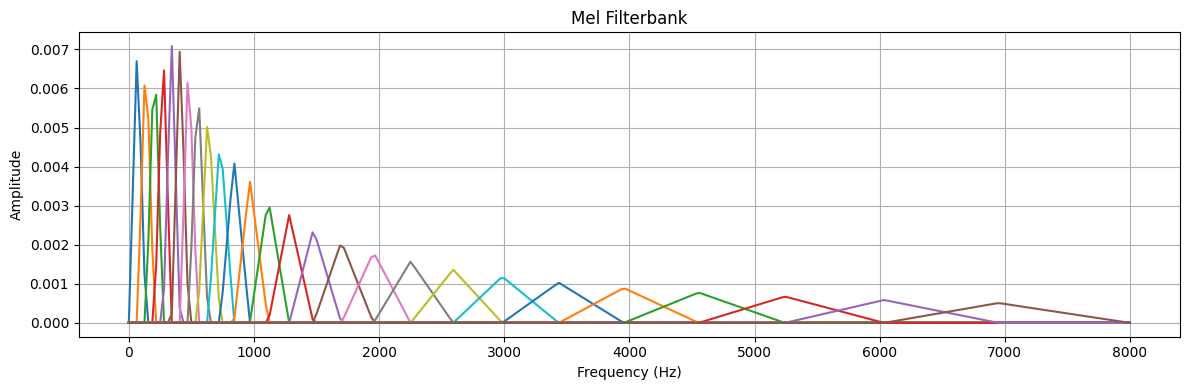

In [ ]:
mfcc, mel_spec_db, mel_filters, freqs = extract_mel_dct_features(
    audio_path='F:/Desktop/BU/MA679/Final/birdclef-2025/train_audio/21038/iNat65519.ogg',
    save_dir='./output'
)
plt.figure(figsize=(12, 4)) 
for i in range(mel_filters.shape[0]):
    plt.plot(fft_freqs, mel_filters[i])
plt.title("Mel Filterbank")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()